# Who survives in the titanic?

> Aim of this notebook is to practice coding in python and to construct my first machine learning workflow.

To do this I will be using the Titanic kaggle problem: https://www.kaggle.com/c/titanic/overview

**Problem statement:** Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

From a top level, this will follow the workflow: 

    1. Data exploration
    2. Feature engineering
    3. Train ML model 
    4. Predict using ML model 
    5. Evaluate predictions
    
On an aside, the following references were used throughout the construction of this notebook:
- https://www.kaggle.com/alexisbcook/titanic-tutorial
- https://www.kaggle.com/daniel68/titanic-a-simple-and-hopefully-clear-approach
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

## Baseline

Before starting any data modelling exercise, it's valuable to determine a baseline. We are told that 1502 (67.5%) of the 2224 passengers and crew did not survive. A simple model that classifies all passengers as "Not Survived" will have a corresponding precision of:

Accuracy = (TP + TN) / (TP + TN + FN + FP) = 2224 / 2946 = 75.5%

Precision = TP/(TP+FP) = 1502 / 2224 = 67.5%

where:

    True Positives (TP) = 1502
    True Negatives (TN) = 722
    False Positives (FP) = 2224 - 1502 = 722
    False Negatives (FN) = 0 as we never predict a negative outcome i.e. Survived.

So these are the scores we need to beat.

## Data exploration

In [5]:
import pandas as pd
import numpy as np

from scipy import stats

# Regular expressions
import re

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import maxabs_scale

# ML model training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn import metrics 

In [8]:
# load in the data and overview of the data structure
train = pd.read_csv("C://Users/rhrey/OneDrive - University College London/Kaggling/titanic/raw_data/train.csv")
test = pd.read_csv("C://Users/rhrey/OneDrive - University College London/Kaggling/titanic/raw_data/test.csv")

In [11]:
print(train.shape) # what are the dimensions/number of training examples?
train.head() # what features do we have?

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
# combine train and test together to use all the most data possible for feature exploration/engineering
data = pd.concat([train, test], sort = True).reset_index(drop = True)

### Which columns have missing values?

In [27]:
for col in data.columns:
    
    print("{} has {} missing values".format(col, str(data[col].isna().sum())))

Age has 263 missing values
Cabin has 1014 missing values
Embarked has 2 missing values
Fare has 1 missing values
Name has 0 missing values
Parch has 0 missing values
PassengerId has 0 missing values
Pclass has 0 missing values
Sex has 0 missing values
SibSp has 0 missing values
Survived has 418 missing values
Ticket has 0 missing values


### Correlation between features

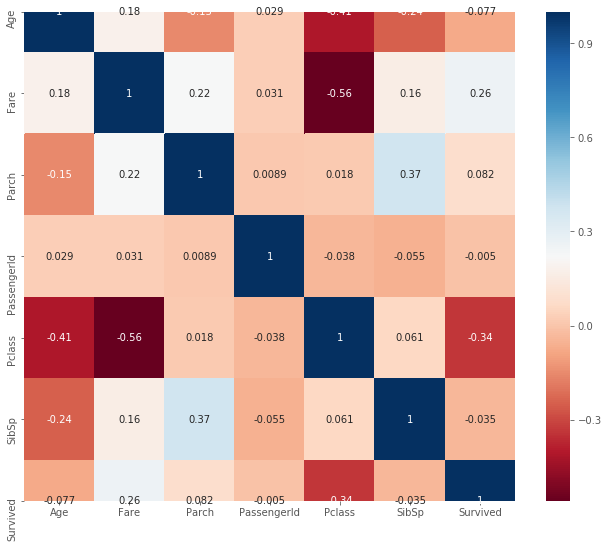

In [30]:
plt.figure(figsize=(11, 9))
sns.heatmap(data.corr("pearson"), 
            cmap = "RdBu", 
            annot = True)